<a href="https://colab.research.google.com/github/mabonmn/Googe_Net_Top5_Prob/blob/main/P5_V1.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoogleNet output

The purpose of this code is to analyse the impact of the different features on the probablity(particulary the top 5) of a particulare frame in a video and how that top 5 catg. changes through the course of the video.

# Packages and Drive Mount

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import cv2
import numpy as np
import os
import pandas as pd
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

Mounted at /content/drive
--2022-04-15 16:26:10--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-04-15 16:26:10 (52.5 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



# Extract frames from video

## Sample Video Frames

In [ ]:
dir='/content/drive/MyDrive/Feature Extraction - Mabon/Top_five_prob-P5/1/'
Number_Of_Top5_To_Graph=3

In [ ]:
'''
#This code extract frames from a video every 15 frames and save them as png files.
vid_path='10.mp4'

path='/content/temp'
isExists = os.path.exists(path)
if not isExists:
  os.makedirs(path)
  print(" The directory was created successfully")
else:
  print(" Directory already exists")


vc = cv2.VideoCapture(vid_path)
number_of_frames = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
print(number_of_frames)
for c in range(number_of_frames):  
  rval, frame = vc.read()
  if (c % 15 == 0):  
    
    cv2.imwrite("%s/"%path+ str(int(c / 15)) + '.png', frame)
dir=path+'/'
dir="/content/temp/"
'''

'\n#This code extract frames from a video every 15 frames and save them as png files.\nvid_path=\'10.mp4\'\n\npath=\'/content/temp\'\nisExists = os.path.exists(path)\nif not isExists:\n  os.makedirs(path)\n  print(" The directory was created successfully")\nelse:\n  print(" Directory already exists")\n\n\nvc = cv2.VideoCapture(vid_path)\nnumber_of_frames = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))\nprint(number_of_frames)\nfor c in range(number_of_frames):  \n  rval, frame = vc.read()\n  if (c % 15 == 0):  \n    \n    cv2.imwrite("%s/"%path+ str(int(c / 15)) + \'.png\', frame)\ndir=path+\'/\'\ndir="/content/temp/"\n'

# Load Model

In [ ]:
files = next(os.walk(dir))[2] #dir is your directory path as string

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]   
 


##Model -1 For Probability (Output: Softmax)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()
print(" ")

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

##Model -2 For Features (Output: Pool-5)

In [ ]:
model2= torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model2 = nn.Sequential(*list(model2.children())[:-1])
model2.eval()
print(" ")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (5): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (bra

# Original Method

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
prob=[]
probcat=[]
major_features= []
top5_prob=None
top5_catid=None
probabilities=None

for i in range(len(files)):
    input_image = Image.open(dir+str(i)+'.png')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

        
    with torch.no_grad():
        output = model(input_batch)
        major_output = model2(input_batch)
        major_output=major_output[0].view(-1).numpy()
    major_features.append(major_output)
    #frame prob using recomended extration from torch.hub
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    prob.append(np.array(top5_prob))
    probcat.append(np.array(top5_catid))
    #print ("prob",top5_prob,top5_catid)
#All Prob are stored in a pandas dataframe
probabilities_dataframe = pd.DataFrame(np.array(prob))
feautres_dataframe=pd.DataFrame(np.array(major_features))

# Proposed Method

In [ ]:
temp = Image.open(dir+'1.png')
w,h=temp.size

s=((224+40)*h)/w
preprocess2 = transforms.Compose([
    transforms.Resize(int(s)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
prob2=[]
categ2=[]
top5_prob=None
top5_catid=None
probabilities=None

for i in range(len(files)):
    path1=dir+str(i)+'.png'
    input_image = Image.open(path1)
    input_tensor = preprocess2(input_image)
    input_batch = input_tensor.unsqueeze(0)       # create a mini-batch as expected by the model
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    with torch.no_grad():
        output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    categ2.append(np.array(top5_catid))
    prob2.append(np.array(top5_prob))
probabilities_dataframe2 = pd.DataFrame(np.array(prob2))

# Plots

In [ ]:
# Show top categories per image
print("FOLLOWING ARE THE TOP 5 CATEGORIES OF THE FRAME WE HAVE CHOSEN TO VIEW :")
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]])

FOLLOWING ARE THE TOP 5 CATEGORIES OF THE FRAME WE HAVE CHOSEN TO VIEW :
window screen
window shade
horizontal bar
prison
greenhouse


In [ ]:
t=[]
plots=[]
for i in range(5):
  a=probabilities_dataframe.iloc[:,i].values
  t.append(a)
  b=probabilities_dataframe2.iloc[:,i].values
  t.append(b)

df = pd.DataFrame(data=t)

a=["TOP1","TOP1 (SM)","TOP2","TOP2 (SM)","TOP3","TOP3 (SM)","TOP4","TOP4 (SM)","TOP5","TOP5 (SM)",]
df=df.transpose()
df.columns=a

In [ ]:

fig=df.plot()
fig.update_layout(
        title="Probability Graph Original Crop V/s Suggested Crop Top-5 Probabilities",
        xaxis_title="Frames",
        yaxis_title="Probability",
        legend_title="Reference",
        yaxis=dict(range=[0,1]),
    )

fig.show()
#fig.write_html("/content/drive/MyDrive/Feature Extraction - Mabon/Top_five_prob-P5/file.html")

# Sample Image AS Per Recomended Crop

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


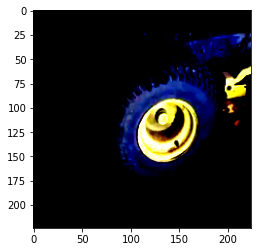

In [ ]:

#sample image crop
path1=dir+str(0)+'.png'
input_image = Image.open(path1)
input_tensor = preprocess2(input_image)
plt.imshow(input_tensor.permute(1, 2, 0))


#CSV FILE WITH FEATURES

In [ ]:
feautres_dataframe.to_csv("Temp.csv")

#Clip

In [ ]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nw90054d
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-nw90054d
     |████████████████████████████████| 53 kB 1.1 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369328 sha256=266260e9df11026711846425840320f6067db1ae61e1a06c9a2bf11fbea114d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-ap51jrcj/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
import clip

#Model

For Clip we have multiple models . For this sample code I have used to models RN50 which Changwei has used and ViT-B/32 is the recomended model to be used. The following are the models that are avaiable:


In [ ]:
print(clip.available_models())

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14']


##Device (for CUDA)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

##RN50 

In [ ]:
#model, preprocess = clip.load('RN50', device)


##ViT-B/32

In [ ]:
model, preprocess = clip.load('ViT-B/32', device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 80.0MiB/s]


#Text Encoder

In [ ]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in categories]).to(device)
with torch.no_grad():
  text_features = model.encode_text(text_inputs)

#Clip Method

In [ ]:
prob3=[]
categ3=[]
top5_prob=None
top5_catid=None
probabilities=None

for i in range(len(files)):
  image_input = preprocess( Image.open(dir+str(i)+'.png')).unsqueeze(0).to(device)
  
  # Calculate features
  with torch.no_grad():
      image_features = model.encode_image(image_input)

  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  probabilities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  top5_prob, top5_catid = probabilities[0].topk(5)
  prob3.append(np.array(top5_prob))
  categ3.append(np.array(top5_catid))

probabilities_dataframe3 = pd.DataFrame(np.array(prob3))

##Sample

In [ ]:
for i in range(1):
  #print(categ3[i])
  #print(prob3[i])
  for j in range(5):
    print(categories[(categ3[i])[j]]+" : "+str(((prob3[i])[j]*100)))

car wheel : 46.12692892551422
tractor : 6.49951696395874
jeep : 5.787266045808792
tow truck : 4.597916081547737
disk brake : 3.690120577812195


In [ ]:
i=100
for j in range(5):
    print(categories[(categ3[i])[j]]+" : "+str(((prob3[i])[j]*100)))

minivan : 23.152461647987366
car wheel : 16.17421656847
car mirror : 10.538162291049957
disk brake : 9.687123447656631
tow truck : 3.385479375720024


#Plots

In [ ]:
t=[]
plots=[]
for i in range(5):
  a=probabilities_dataframe3.iloc[:,i].values
  t.append(a)
  b=probabilities_dataframe.iloc[:,i].values
  t.append(b)

df2 = pd.DataFrame(data=t)

a=["TOP1","TOP1 (GN)","TOP2","TOP2 (GN)","TOP3","TOP3 (GN)","TOP4","TOP4 (GN)","TOP5","TOP5 (GN)",]
df2=df2.transpose()
df2.columns=a

In [ ]:
# This plot is used to represent the top 5 cats of Clip v/s GoogLeNet.

fig2=df2.plot()
fig2.update_layout(
        title="Probability Graph Clip Vs GoogLeNet Probabilities",
        xaxis_title="Frames",
        yaxis_title="Probability",
        legend_title="Reference",
        yaxis=dict(range=[0,1]),
    )

fig2.show()
#fig2.write_html("/content/drive/MyDrive/Feature Extraction - Mabon/Top_five_prob-P5/file-gnvsclip.html")

#Category CLassification 

Enter the frame whose categories you want to view

In [ ]:
Frame_number=97

##CLIP

CLIP: 
minivan : 22.708819806575775
car wheel : 10.15264242887497
disk brake : 7.256706804037094
tow truck : 6.2560074031353
cab : 5.358226224780083


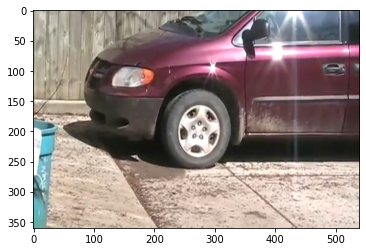

In [ ]:
print("CLIP: ")
for j in range(5):
    print(categories[(categ3[Frame_number])[j]]+" : "+str(((prob3[Frame_number])[j]*100)))
plt.imshow(Image.open(dir+str(Frame_number)+'.png'))

##GoogLeNet

GOOGLENET: 
minivan : 54.11444306373596
minibus : 8.256421983242035
tow truck : 6.091214343905449
recreational vehicle : 4.343760013580322
ambulance : 3.576282039284706


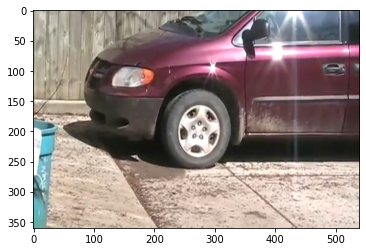

In [ ]:
print("GOOGLENET: ")
for j in range(5):
    print(categories[(probcat[Frame_number])[j]]+" : "+str(((prob[Frame_number])[j]*100)))
plt.imshow(Image.open(dir+str(Frame_number)+'.png'))

##GoogLeNet Suggested crop

GOOGLENET (Sugested Crop): 
minivan : 70.28972506523132
beach wagon : 4.688046500086784
minibus : 3.0332930386066437
jeep : 2.177191711962223
recreational vehicle : 1.2493852525949478


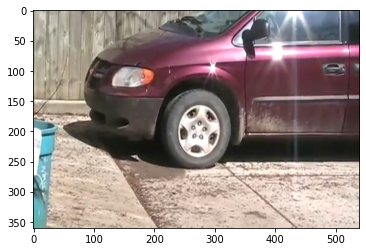

In [ ]:
print("GOOGLENET (Sugested Crop): ")
for j in range(5):
    print(categories[(categ2[Frame_number])[j]]+" : "+str(((prob2[Frame_number])[j]*100)))
plt.imshow(Image.open(dir+str(Frame_number)+'.png'))